In [2]:
# !pip install osml-imagery-toolkit

# Examples of SICD Data Using OversightML Imagery Toolkit

The data used in these examples was provided by Capella and Umbra as part of the AWS Open Data program.  
The files can be found in the open data catalog or downloaded directly using the links below.



In [3]:
#!wget https://capella-open-data.s3.amazonaws.com/data/2021/9/30/CAPELLA_C03_SP_SICD_HH_20210930100314_20210930100317/CAPELLA_C03_SP_SICD_HH_20210930100314_20210930100317.ntf
#!wget https://capella-open-data.s3.amazonaws.com/data/2021/2/2/CAPELLA_C02_SM_SICD_HH_20210202043514_20210202043519/CAPELLA_C02_SM_SICD_HH_20210202043514_20210202043519.ntf
#!wget https://umbra-open-data-catalog.s3.amazonaws.com/sar-data/tasks/Melbourne,%20Australia/b90c0aa0-ff9b-480c-b866-5f3778e8f013/2023-04-01-22-58-40_UMBRA-04/2023-04-01-22-58-40_UMBRA-04_SICD.nitf

In [4]:
from osgeo import gdal, gdalconst
gdal.UseExceptions()

In [5]:
from aws.osml.gdal import load_gdal_dataset, GDALImageFormats, GDALCompressionOptions
from aws.osml.image_processing import GDALTileFactory

In [6]:
#image_file = "./CAPELLA_C03_SP_SICD_HH_20210930100314_20210930100317.ntf"
#image_file = "./CAPELLA_C02_SM_SICD_HH_20210202043514_20210202043519.ntf"
image_file = "./2023-04-01-22-58-40_UMBRA-04_SICD.nitf"
sicd_dataset, sm = load_gdal_dataset(image_file)
width = sicd_dataset.RasterXSize
height = sicd_dataset.RasterYSize

print(f"Loaded SICD image with dimensions: ({height}, {width}) (rows, cols)") 
print(f"Using Sensor Model Implementation: {type(sm.precision_sensor_model).__name__}")

Loaded SICD image with dimensions: (10599, 10626) (rows, cols)
Using Sensor Model Implementation: SICDSensorModel


## Example Create SICD Image Tiles with Updated Metadata
Create a GDALTileFactory that will produce SICD tiles. Setting the output format to NITF format will cause the GDALTileFactory 
to update the ImageData XML elements to reflect the reduced image dimensions. These updates are necessary to allow consumers
of the tile to correctly calculate image/world positions for the pixels. The following example shows SICD metadata for a 
512x512 tile with an upper left corner that was at row 5043 and column 5057. Note that the original full image size is preserved
while NumRows and NumCols have been updated to be the current tile size.

    <ImageData>
		...
		<NumRows>512</NumRows>
		<NumCols>512</NumCols>
		<FirstRow>5043</FirstRow>
		<FirstCol>5057</FirstCol>
		<FullImage>
			<NumRows>10599</NumRows>
			<NumCols>10626</NumCols>
		</FullImage>
        ...
    </ImageData>

The image is saved to a file to demonstrate that the data has been correctly updated.


In [7]:
tile_factory = GDALTileFactory(sicd_dataset, sm, GDALImageFormats.NITF, GDALCompressionOptions.NONE)

center_x = width / 2
center_y = height / 2
tile_size = 512
image_tile = tile_factory.create_encoded_tile([int(center_x - tile_size/2),
                                               int(center_y - tile_size/2),
                                               tile_size,
                                               tile_size])

with open("./sample-sicd-tile.ntf", "wb") as output_file:
    output_file.write(image_tile)

ERROR 6: The 4 GCPs image coordinates must be exactly at the *center* of the 4 corners of the image ( (0.5, 0.5), (511.5 0.5), (511.5 511.5), (511.5 0.5) ).


## Example Demonstrate Use of SICD Sensor Models
This example demonstrates how the SICD sensor model's image_to_world function can be used to convert
image coordinates (x, y) to world coordinates (longitude, latitude, elevation). The corners of both the
full image and the previously created SICD tile are used to create polygons that show the extent of each
image on the ground then those footprints are overlaid on a map for comparison.

In [8]:
from ipyleaflet import *
from aws.osml.photogrammetry import ImageCoordinate, GeodeticWorldCoordinate
from math import degrees

In [9]:
# Load the previously saved SICD tile cut from the center of the image
sicd_tile, tile_sm = load_gdal_dataset("./sample-sicd-tile.ntf")

# Compute WGS-84 world coordinates for each image corner and create a red polygon 
# to show the full image footprint
image_corners = [[0, 0], [width, 0], [width, height], [0, height]]
geo_image_corners = [sm.image_to_world(ImageCoordinate(corner)) for corner in image_corners]
locations = [(degrees(p.latitude), degrees(p.longitude)) for p in geo_image_corners]
locations.append(locations[0])
               
image_footprint = Polygon(
    locations=locations,
    color="green",
    fill_color="green"
)

# Compute the WGS-84 world coordinates for each tile corner and create a red polygon 
# to show the tile footprint
tile_corners = [[0, 0], [tile_size, 0], [tile_size, tile_size], [0, tile_size]]
geo_tile_corners = [tile_sm.image_to_world(ImageCoordinate(corner)) for corner in tile_corners]
tile_locations = [(degrees(p.latitude), degrees(p.longitude)) for p in geo_tile_corners]
tile_locations.append(tile_locations[0])

tile_footprint = Polygon(
    locations=tile_locations,
    color="red",
    fill_color="red"
)

# Compute the WGS-84 center of the image so we can center the map
center_geo = sm.image_to_world(ImageCoordinate([center_x, center_y]))
center = (degrees(center_geo.latitude),
          degrees(center_geo.longitude))

# Render the map and overlays using Leaflet
m = Map(center=center, zoom=12, basemap=basemaps.OpenStreetMap.Mapnik)
m.add_layer(image_footprint)
m.add_layer(tile_footprint)
m

Map(center=[-37.846022478600695, 144.91293953312228], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Example Dump SICD Metadata
This example shows how to identify the NITF data extension segment containing SICD metadata and prety print it
for review. 

In [10]:
import base64
import xml.dom.minidom
from aws.osml.gdal import NITFDESAccessor

In [11]:
des_accessor = NITFDESAccessor(sicd_tile.GetMetadata("xml:DES"))
xml_data_content_segments = des_accessor.get_segments_by_name("XML_DATA_CONTENT")
if xml_data_content_segments is not None:
    for xml_data_segment in xml_data_content_segments:
        xml_bytes = des_accessor.parse_field_value(xml_data_segment, "DESDATA", base64.b64decode)
        xml_str = xml_bytes.decode("utf-8")
        if "SICD" in xml_str:
            temp = xml.dom.minidom.parseString(xml_str)
            new_xml = temp.toprettyxml()
            print(new_xml)
            break

<?xml version="1.0" ?>
<ns0:SICD xmlns:ns0="urn:SICD:1.2.1">
	<ns0:CollectionInfo>
		<ns0:CollectorName>Umbra-04</ns0:CollectorName>
		<ns0:CoreName>2023-04-01T22:58:42_Umbra-04</ns0:CoreName>
		<ns0:CollectType>MONOSTATIC</ns0:CollectType>
		<ns0:RadarMode>
			<ns0:ModeType>SPOTLIGHT</ns0:ModeType>
		</ns0:RadarMode>
		<ns0:Classification>UNCLASSIFIED - https://creativecommons.org/licenses/by/4.0/</ns0:Classification>
		<ns0:Parameter name="task_id">4675b40d-27a0-4c43-9799-20b971c5543c</ns0:Parameter>
	</ns0:CollectionInfo>
	<ns0:ImageCreation>
		<ns0:Application>Valkyrie Systems Sage | Umbra Image Formation processor 0.3.22.0</ns0:Application>
		<ns0:DateTime>2023-04-02T03:05:08.045326Z</ns0:DateTime>
	</ns0:ImageCreation>
	<ns0:ImageData>
		<ns0:PixelType>RE32F_IM32F</ns0:PixelType>
		<ns0:NumRows>512</ns0:NumRows>
		<ns0:NumCols>512</ns0:NumCols>
		<ns0:FirstRow>5043</ns0:FirstRow>
		<ns0:FirstCol>5057</ns0:FirstCol>
		<ns0:FullImage>
			<ns0:NumRows>10599</ns0:NumRows>
			<ns0:Num

## Experimental: Visualization of Complex Data
There are a variety of different techniques to convert complex SAR data to a simple image suitable for human display.
The toolkit contains two helper functions that can convert complex image data into an 8-bit grayscle representation
The equations are described in Sections 3.1 and 3.2 of SAR Image Scaling, Dynamic Range, Radiometric Calibration,
and Display ([SAND2019-2371](https://www.osti.gov/servlets/purl/1761879)).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from aws.osml.image_processing import histogram_stretch, quarter_power_image

In [13]:
def plot_image(pixels,show_histo = False):
    min_value = np.min(pixels)
    max_value = np.max(pixels)
    #print(f"Pixels in range of: {min_value} .. {max_value}")
    
    if show_histo:
        f, axs = plt.subplots(1, 2, figsize=(15,10), gridspec_kw={'width_ratios': [2, 1]})
        img_axs = axs[0]
    else:
        f, axs = plt.subplots(1, 1, figsize=(10,10))
        img_axs = axs
    
    f.tight_layout()
    img_axs.imshow(pixels, cmap="grey", vmin=min_value, vmax=max_value)
    img_axs.set_axis_off()
    
    if show_histo:
        counts, bins = np.histogram(pixels, bins=256)
        axs[1].set_yscale('log')
        axs[1].stairs(counts, bins)


In [14]:
complex_pixels = sicd_dataset.ReadAsArray()

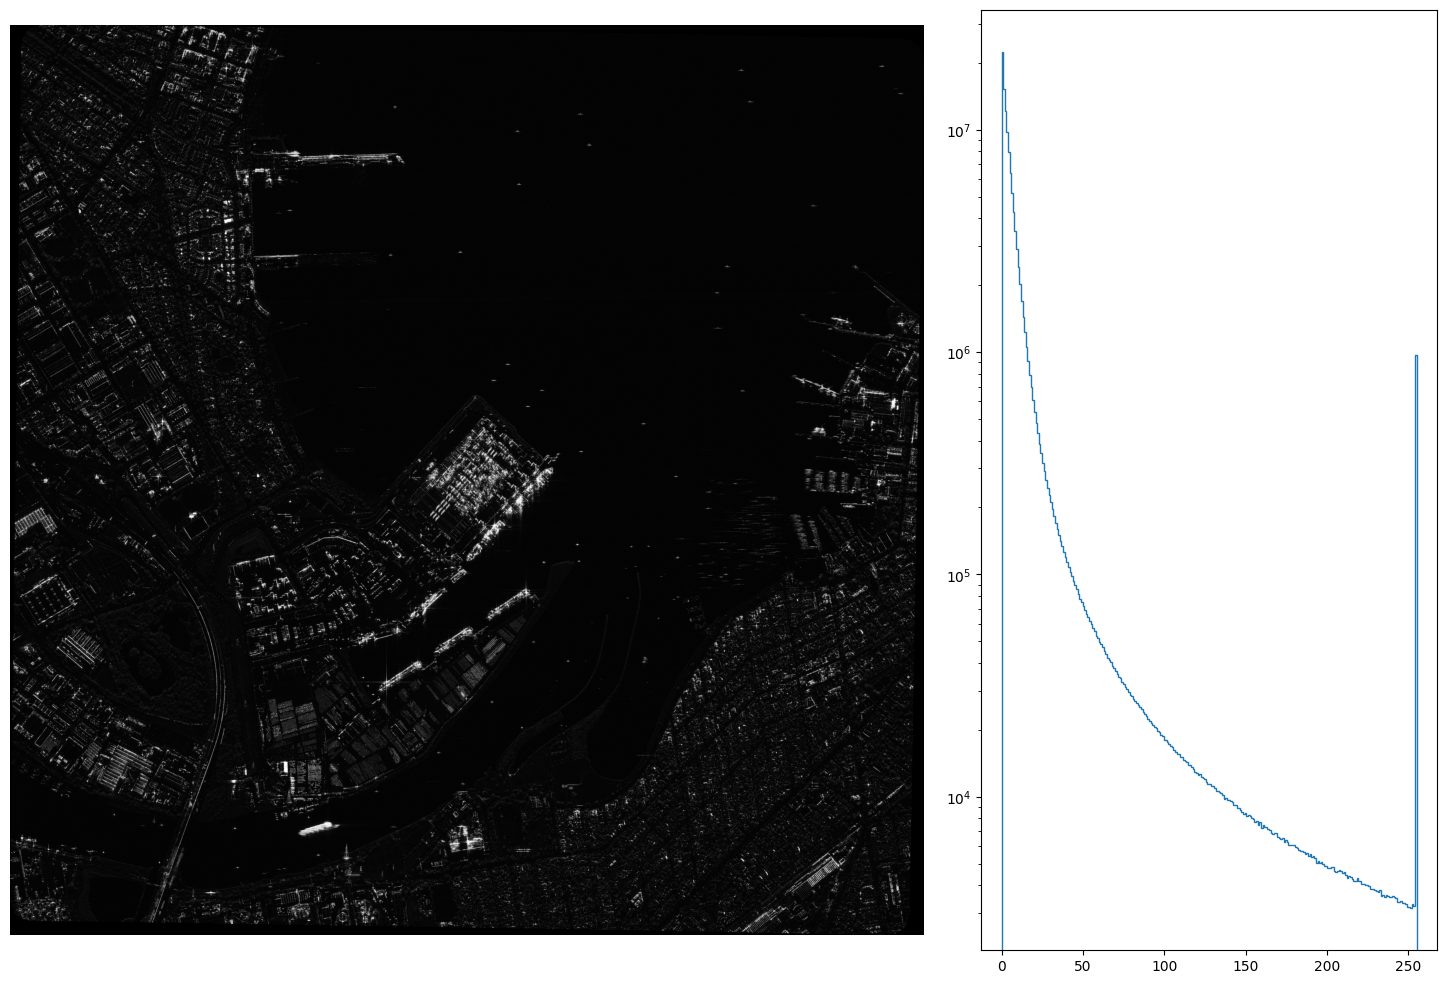

In [15]:
plot_image(histogram_stretch(complex_pixels), show_histo=True)

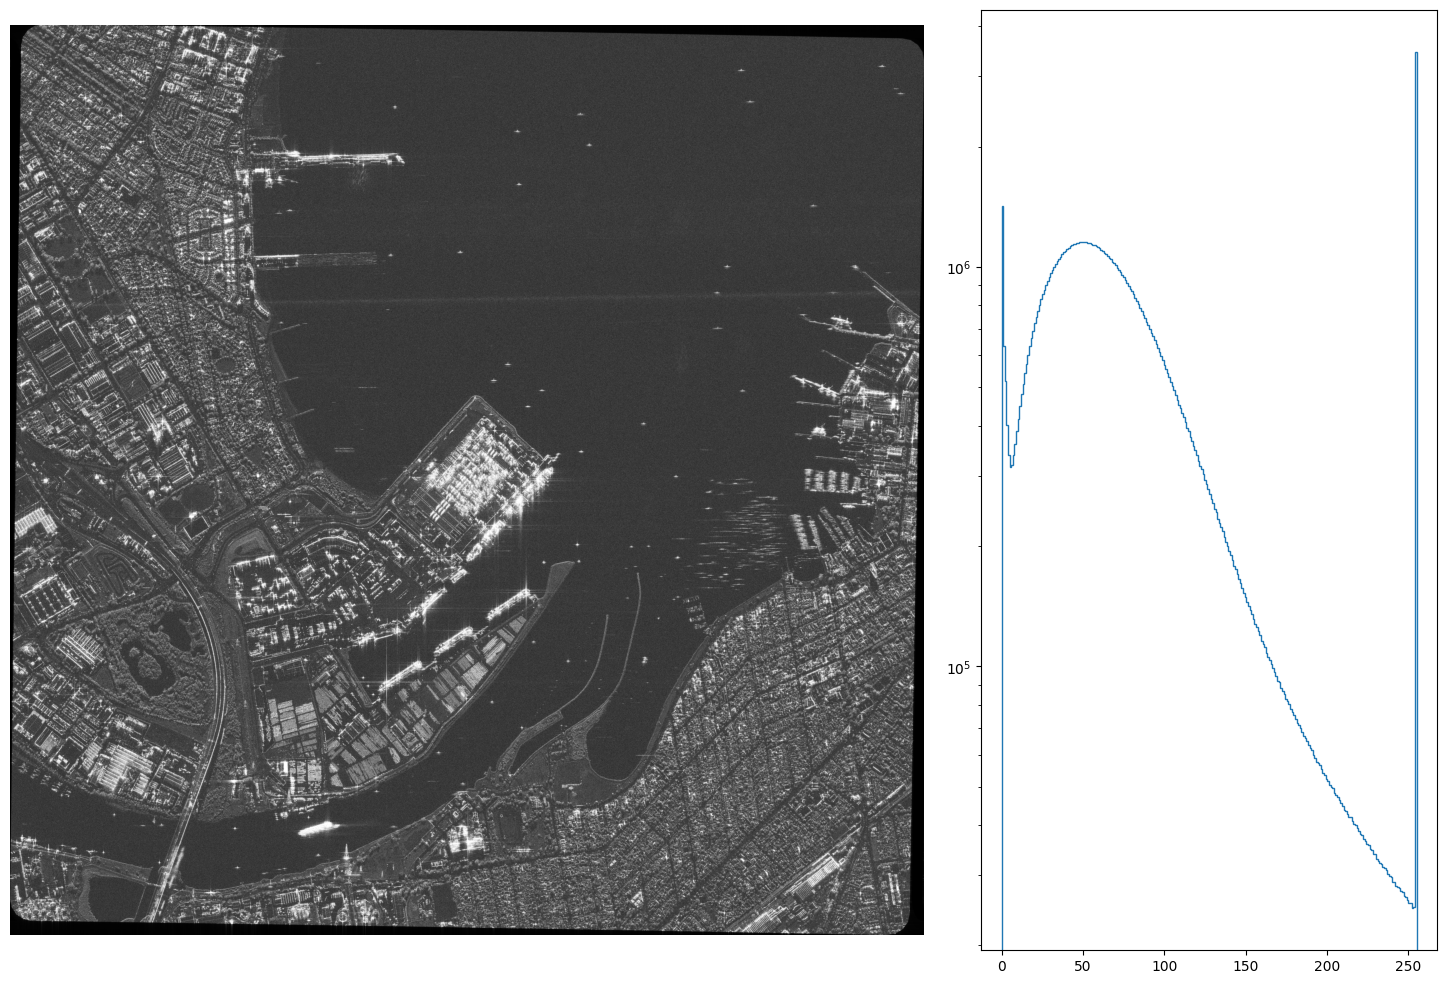

In [16]:
plot_image(quarter_power_image(complex_pixels), show_histo=True)